# Web Scraping Zolo.ca

#### This project was completed in May 2019 while I was a student at WeCloudData and edited in August 2020 for my portfolio. The purpose was to scrape real estate listings from Zolo.ca, clean and visualize data in Python, then build a Plotly Dashboard to present key insights. The hope was to gain a better understanding of which neighborhoods were the best and worst value. Since completing this project the layout of Zolo.ca has changed so my code would need to be tweaked to scrape current data. As a result I can not recreate the original Plotly dashboard here. The main graph showed the top 10 neighborhoods for price divide by one of 5 selectable metrics (e.g. price / bedroom, price / sqft, etc.). You could also toggle to the worst 10 neighborhoods. I have included a PowerPoint that I made to present my work. 

In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import json # For parsing json
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from selenium import webdriver #for automated clicking between pages
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
import re
import os

In [3]:
num_listings = 120
list_p_page = 24
city = 'toronto'

#Launch Chrome browser
driver = webdriver.Chrome(r"/Users/samanthamiller/Desktop/Python/Webscraping Project/chromedriver")
base_url = f'https://www.zolo.ca/{city}-real-estate'
driver.get(base_url)
driver.implicitly_wait(5)

yolo = {}

#loops through website's pages
for j in range((num_listings//list_p_page)+1):
    houses = pd.DataFrame()
    
    #loops through listings on 1 page
    for i in range(list_p_page):
        driver.implicitly_wait(3)
        try:
            link = driver.find_elements_by_class_name('address')[i]
            link.click()
        except:
            pass
        
        html = driver.page_source
        soup = BeautifulSoup(html)
        value = []
        info = [] 
        
        #Random time lags were put in to avoid being detected as a webscraper
        driver.implicitly_wait(3)
       
        #Clicks through webscraping security pop-up
        try:
            scrape = driver.find_element_by_id('filterbutton')
            scrape.click()
        except:
            pass
        
        try:
        #Essentials table    
            houses.loc[i,'Address'] = soup.find('h1', "address xs-text-2 sm-text-1 truncate bold").get_text(strip=True)
            houses.loc[i,'City'] = soup.find_all('a',class_="link-primary")[0].get_text(strip=True)
            houses.loc[i,'Neighbourhood'] = soup.find_all('a',class_="link-primary")[1].get_text(strip=True)
            houses.loc[i,'Price'] = soup.find('div', "xs-text-2 sm-text-1 bold xs-inline sm-block xs-mr05 sm-mr0").get_text(strip=True)
        #First extras table
            temp = soup.find('div',class_='column-gap').get_text().replace('Listed By','Listed By\n').split('\n')
            temp = list(filter(None, temp))
            
            for idx in range(len(temp)):
                if idx % 2 == 1:
                    value.append(temp[idx])
                if idx % 2 == 0:
                    info.append(temp[idx])
        
        #Second extras table      
            for x in soup.find_all('div',class_='column'):
                value.append(x.get_text().split('\n')[2])
                info.append(x.get_text().split('\n')[1])
        
        #Transpose extras table
            extras = pd.DataFrame({'info_type':info, 'value':value})
            for z in range(len(extras)):
                houses.loc[i, extras['info_type'][z]] = extras['value'][z]
        except:
            pass
        
        #Clicks back to multi-listing page
        driver.implicitly_wait(3)
        try:
            back_button = driver.find_element_by_xpath('/html/body/div[1]/nav/div/button')
            back_button.click()
        except:
            pass
    
    yolo[j] = houses
    
    #Workaround for button list expanding after page 5:
    try:
        if j <= 3:
            driver.implicitly_wait(3)
            next_page = driver.find_element_by_xpath('//*[@id="listing_container"]/section[3]/nav[1]/a[7]').click()
            next_page
        else:
            driver.implicitly_wait(3)
            next_page = driver.find_element_by_xpath('//*[@id="listing_container"]/section[3]/nav[1]/a[8]').click()
            next_page
    except:
        pass

y_zolo = pd.concat(yolo.values(), sort=False)
y_zolo.reset_index(inplace=True)
y_zolo

,index,Address,City,Neighbourhood,Price,Type,Style,Size,Age,Pets,...,Living Area,Building Area Units,Levels,Attached Garage,Parking Spaces,"Prominent Realty Inc., Brokerage",Century 21 Titans Realty Inc.,Re/max Royal Properties Realty,GreenProperty Info Statement,Green Verification Status
0,0,2070 - 3041 Finch Avenue,Toronto,Humbermede,"$346,790",Condo Apt,Stacked Townhse,500-599 sqft,No Data,Restrict,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,238 Combe Avenue,Toronto,Bathurst Manor,"$1,999,000",Detached,2-Storey,3000-3500 sqft,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,15 Reesor Road,Toronto,Rouge E11,"$1,399,000",Detached,2-Storey,No Data,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,60 Clappison Boulevard,Toronto,Centennial Scarborough,"$679,900",Semi-Detached,Bungalow-Raised,1100-1500 sqft,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,15 Ethel Bell Terrace,Toronto,Clairlea-birchmount,"$798,000",Att/Row/Twnhouse,3-Storey,2000-2500 sqft,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1130 Roselawn Avenue,Toronto,Briar Hill-belgravia,"$1,029,000",Detached,2-Storey,No Data,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,11737 Sheppard Avenue,Toronto,Rouge E11,"$645,000",Att/Row/Twnhouse,3-Storey,2000-2500 sqft,No Data,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,1001 - 15 Windermere Avenue,Toronto,High Park-swansea,"$509,000",Condo Apt,Apartment,600-699 sqft,No Data,Restrict,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2809 - 36 Park Lawn Road,Toronto,Mimico,"$589,000",Comm Element Condo,Multi-Level,600-699 sqft,No Data,Restrict,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1006 - 80 Esther Lorrie Drive,Toronto,West Humber-clairville,"$472,500",Condo Apt,Apartment,800-899 sqft,No Data,Restrict,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
#Describe df
with pd.option_context('display.max_columns', None):
    display(y_zolo.describe(include = 'all'))

,Address,Air Conditioning,Amenity,Association Name,Bathrooms,Bedrooms,Bedrooms Plus,Building Insurance Included,Central A/C Included,Common Elements Included,Community,Condo Registry Office,Covered Parking Places,Cross Street,Days on Site,Den/Family Room,Driveway,Exterior,Fireplace,Frontage,Fronting On,Garage,Heating,Heating Included,Kitchens,Laundry,Listed By,Lockers,Lot Depth,Lot Size Units,Maintenance Fees,Municipality District,Neighbourhood,Parking Included,Parking Places,Patio Terrace,Pets,Price,Rooms,Rooms Plus,Sewer,Stories,Style,Tax Year,Taxes,Type,Virtual Tour,Walk Score,Sq_ft,Lot Size Total
count,877,812,180,340,870.000000,857.000000,410,339,225,340,816,343,618.000000,816,877.000000,260,469,212,280,476.000000,813,863,870,249,812.000000,422,877,343,470.000000,473,340.000000,816,877,280,736.000000,343,380,8.770000e+02,811.000000,394.000000,472,360.000000,876,815.000000,798.000000,877,428,870.000000,537.000000,470.000000
unique,877,5,14,213,NaN,NaN,4,1,1,1,137,25,NaN,731,NaN,1,10,11,1,NaN,10,10,10,1,NaN,3,275,6,NaN,2,NaN,35,142,1,NaN,5,2,NaN,NaN,NaN,5,NaN,22,NaN,NaN,17,427,NaN,NaN,NaN
top,98 Curzon Street,Central Air,Visitor Parking,Del Property Management,NaN,NaN,1,Yes,Yes,Yes,Waterfront Communities C1,TSCC,NaN,Yonge/Sheppard,NaN,Yes,Private,Stucco/Plaster,Yes,NaN,E,Undergrnd,Forced Air,Yes,NaN,"Main, Main level","Royal Lepage Signature Realty, Brokerage",Owned,NaN,Feet,NaN,Toronto C01,Waterfront Communities C1,Yes,NaN,Open,Restrict,NaN,NaN,NaN,Sewers,NaN,2-Storey,NaN,NaN,Detached,http://www.myvisuallistings.com/vtnb/279974,NaN,NaN,NaN
freq,1,742,122,35,NaN,NaN,330,339,225,340,43,176,NaN,13,NaN,260,264,48,280,NaN,170,293,715,249,NaN,201,40,184,NaN,469,NaN,97,48,280,NaN,215,327,NaN,NaN,NaN,463,NaN,280,NaN,NaN,348,2,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2.445977,2.688448,NaN,NaN,NaN,NaN,NaN,NaN,1.298544,NaN,1.868871,NaN,NaN,NaN,NaN,37.155693,NaN,NaN,NaN,NaN,1.068966,NaN,NaN,NaN,120.111532,NaN,642.835294,NaN,NaN,NaN,2.718071,NaN,NaN,1.107113e+06,6.520345,2.269036,NaN,10.275000,NaN,2023.522699,4537.059248,NaN,NaN,71.310345,1272.806331,4815.121770
std,NaN,NaN,NaN,NaN,1.308097,1.125229,NaN,NaN,NaN,NaN,NaN,NaN,0.576651,NaN,3.558372,NaN,NaN,NaN,NaN,18.185201,NaN,NaN,NaN,NaN,0.322096,NaN,NaN,NaN,35.681343,NaN,384.158479,NaN,NaN,NaN,2.183036,NaN,NaN,9.184094e+05,2.016725,1.241236,NaN,10.279286,NaN,143.880920,5802.087176,NaN,NaN,21.502862,842.739450,4424.481089
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,25.950000,NaN,160.000000,NaN,NaN,NaN,1.000000,NaN,NaN,7.500000e+04,1.000000,1.000000,NaN,1.000000,NaN,2018.000000,35.000000,NaN,NaN,3.000000,249.500000,222.910500
25%,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,23.460000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,104.910000,NaN,422.000000,NaN,NaN,NaN,1.000000,NaN,NaN,6.099000e+05,5.000000,1.000000,NaN,2.750000,NaN,2018.000000,2433.992500,NaN,NaN,56.000000,749.500000,2541.980000
50%,NaN,NaN,NaN,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,33.665000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,118.850000,NaN,548.500000,NaN,NaN,NaN,2.000000,NaN,NaN,8.249000e+05,6.000000,2.000000,NaN,7.000000,NaN,2018.000000,3414.550000,NaN,NaN,74.000000,1099.500000,3953.714050
75%,NaN,NaN,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,2.000000,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,130.000000,NaN,746.500000,NaN,NaN,NaN,4.000000,NaN,NaN,1.288888e+06,8.000000,3.000000,NaN,14.000000,NaN,2019.000000,5015.130000,NaN,NaN,90.000000,1499.500000,6003.702500


## Data Cleaning

### In hindsight, the following column previews should have been run as .head() instead of displaying the full column. Unfortunately, I can not rerun them without the original data. While I can control this in my Jupyter notebook, Github previews will display the full output. My apologies. 

In [ ]:
#To remove columns w/ 80%+ N/A values
thresh = len(y_zolo) * .2
y_zolo.dropna(thresh = thresh, axis = 1, inplace = True)

In [ ]:
#Drop duplicate addresses
y_zolo = DataFrame.drop_duplicates(y_zolo)

#Remove redundant and non-descriptive columns
y_zolo = y_zolo.drop(columns=['Age','Area','City','Corporation Number','Lot Size','MLS®#', \
        'Property Type','Size','Tax Legal Description','Maintenance', \
        'index','Availability Date','Basement','Parking Designation'])

#Reset index
y_zolo.reset_index(inplace=True)

In [155]:
#Clean up 'Price'
y_zolo['Price'] = y_zolo['Price'].str.replace('$','').str.replace(',','')
y_zolo['Price'] = y_zolo['Price'].apply(lambda x: float(x))
y_zolo['Price']

0        427000.0
1        725000.0
2        799000.0
3        649007.0
4        830000.0
5        898800.0
6        664999.0
7        799000.0
8        450000.0
9       2088000.0
10      2750000.0
11       929000.0
12      1340000.0
13      1129000.0
14       799000.0
15      1329900.0
16       775000.0
17      1788000.0
18       849900.0
19       675000.0
20       779000.0
21       535000.0
22       998888.0
23      1899000.0
24      1250000.0
25      1600000.0
26      1699900.0
27      2699000.0
28      1538000.0
29      1898000.0
          ...    
972           NaN
973           NaN
974           NaN
975           NaN
976           NaN
977           NaN
978           NaN
979           NaN
980           NaN
981           NaN
982           NaN
983           NaN
984           NaN
985           NaN
986           NaN
987           NaN
988           NaN
989           NaN
990           NaN
991           NaN
992           NaN
993           NaN
994           NaN
995           NaN
996       

In [54]:
#Clean up 'Maintenance Fees' and 'Frontage'
y_zolo['Maintenance Fees'] = y_zolo['Maintenance Fees'].str.replace('$','').str.replace(',','') \
    .str.replace('/ mo','').str.replace('/mo','')
y_zolo['Frontage'] = y_zolo['Frontage'].str.replace('ft','').str.strip()
y_zolo['Frontage']

0        NaN
1        NaN
2      42.48
3        NaN
4      30.18
5        NaN
6      18.59
7      30.09
8        NaN
9      52.21
10     59.00
11     41.21
12     50.00
13     47.25
14     16.86
15     25.00
16     50.00
17     50.00
18     50.00
19     15.49
20     40.00
21     14.17
22     58.93
23     54.50
24     40.00
25     20.50
26     52.00
27     48.75
28     24.17
29     50.00
       ...  
853    18.50
854    16.50
855    14.60
856    25.00
857    35.00
858    50.00
859    35.21
860    30.00
861    19.06
862    26.54
863    76.00
864    40.00
865    25.00
866    17.50
867    36.04
868    45.00
869    40.00
870    50.00
871    30.00
872    50.00
873    50.44
874    87.01
875    56.00
876    20.00
877    55.00
878    27.24
879    30.91
880    50.00
881    23.50
882    60.00
Name: Frontage, Length: 882, dtype: object

In [171]:
#Clean up 'Sq_ft'
sq = []

for sqft in y_zolo['Size (sq ft)']:
    if type(sqft) == str:
        if '-' in sqft:
            sqft = (float(sqft.split('-')[0])+float(sqft.split('-')[1]))/2
            #print(sqft)
        else:
            sqft = float(sqft)
            #print(sqft)
    sq.append(sqft)

y_zolo['Size (sq ft)'] = sq
            
y_zolo['Sq_ft'] = y_zolo['Size (sq ft)']
y_zolo = y_zolo.drop(columns=['Size (sq ft)'])
y_zolo

,index,Address,Air Conditioning,Amenity,Association Name,Availability Date,Basement,Bathrooms,Bedrooms,Bedrooms Plus,...,Rooms Plus,Sewer,Stories,Style,Tax Year,Taxes,Type,Virtual Tour,Walk Score,Sq_ft
0,0,215 - 25 Sunny Glenway Drive,Window Unit,NaN,Comfort Property Managment,Immediate,NaN,2,3,NaN,...,NaN,NaN,2,2-Storey,2018,1358,Condo Townhouse,NaN,62,1099.5
1,1,714 - 701 Sheppard Avenue,Central Air,Visitor Parking,"Www.Goldview.Ca 416-630-1234 51 Toro Rd, Suite...",Flexible-Tba,NaN,2,2,1,...,NaN,NaN,7,Apartment,2019,3061.55,Condo Apt,NaN,68,1099.5
2,2,67 Hutcherson Square,Central Air,NaN,NaN,NaN,"Full, Full",2,4,1,...,NaN,Sewers,NaN,2-Storey,2018,3000,Detached,NaN,57,1300.0
3,3,9 - 50 Markham Road,Central Air,NaN,Mtcc 1274,Flexible,NaN,3,3,NaN,...,1,NaN,1,2-Storey,2018,2016,Condo Townhouse,https://unbranded.mediatours.ca/property/9-50-...,73,1699.5
4,4,33 Waterbridge Way,Central Air,NaN,NaN,60 Days/Tba,NaN,4,3,1,...,NaN,Sewers,NaN,2-Storey,2019,3777.77,Detached,http://www.houssmax.ca/vtournb/h7079253,28,1750.0
5,5,3903 - 23 Hollywood Avenue,Central Air,Sauna,Del Property Management,Tba,NaN,2,2,1,...,1,NaN,34,Apartment,2018,3800,Condo Apt,NaN,97,1299.5
6,6,11737 Sheppard Avenue,Central Air,NaN,NaN,Tba,NaN,3,3,1,...,1,Sewers,NaN,3-Storey,2018,2685.01,Att/Row/Twnhouse,https://www.zolo.ca/toronto-real-estate/11737-...,53,2250.0
7,7,117 Sawmill Road,Central Air,NaN,NaN,30/60,NaN,3,3,NaN,...,2,Sewers,NaN,Bungalow-Raised,2018,3047,Link,https://www.zolo.ca/toronto-real-estate/117-sa...,50,NaN
8,8,199b - 165 Cherokee Boulevard,Central Air,Visitor Parking,Shiupong.Com 416-596-8885,Flexible Tba,NaN,2,3,NaN,...,NaN,NaN,1,2-Storey,2018,1674.56,Condo Townhouse,NaN,45,1299.5
9,9,238 Combe Avenue,Central Air,NaN,NaN,Tba,"Sep Entrance, Sep Entrance",5,5,2,...,3,Sewers,NaN,2-Storey,2019,8880,Detached,https://www.zolo.ca/toronto-real-estate/238-co...,75,3250.0


In [433]:
#More efficient code to clean up 'Sq_ft'
safe_zolo['Size (sq ft)'].str.split('-', expand=True).astype(float).sum(axis=1) / 2

0       1099.5
1       1099.5
2       1300.0
3       1699.5
4       1750.0
5       1299.5
6       2250.0
7          0.0
8       1299.5
9       3250.0
10      4250.0
11         0.0
12         0.0
13      1750.0
14         0.0
15         0.0
16         0.0
17      1750.0
18         0.0
19      1750.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26      2250.0
27         0.0
28         0.0
29      1750.0
         ...  
972        0.0
973        0.0
974     1300.0
975        0.0
976        0.0
977        0.0
978     1750.0
979        0.0
980        0.0
981        0.0
982        0.0
983     2750.0
984     4250.0
985        0.0
986        0.0
987        0.0
988     4250.0
989        0.0
990        0.0
991        0.0
992        0.0
993     2750.0
994     4250.0
995     1750.0
996        0.0
997     1300.0
998        0.0
999        0.0
1000       0.0
1001       0.0
Length: 1002, dtype: float64

In [187]:
#Clean up 'Taxes'
y_zolo.loc[y_zolo['Taxes'] == 'Nan', 'Taxes'] = np.nan

/Users/samanthamiller/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [197]:
#Clean up 'Walk Score'
y_zolo.loc[y_zolo['Walk Score'] == '-', 'Walk Score'] = np.nan

In [385]:
#Clean up 'Neighbourhood'
y_zolo.loc[y_zolo['Neighbourhood'] == 'Walk Score','Neighbourhood'] = 'Unknown'

In [ ]:
#Clean up 'Days on Site'
dos = []
for line in y_zolo['Days on Site']:
    dos.append(float(line.split()[0]))
y_zolo['Days on Site'] = dos

In [275]:
#Engineer Lot Size Total column
y_zolo['Lot Size Total'] = y_zolo['Lot Depth']*y_zolo['Frontage']
y_zolo['Lot Size Total']

0             NaN
1             NaN
2       5327.4168
3             NaN
4       3267.5886
5             NaN
6       2795.3783
7       3307.1919
8             NaN
9       6004.1500
10      7611.0000
11      4866.0768
12      5682.0000
13      5523.9975
14      1944.4638
15      3136.5000
16      6100.0000
17      5550.0000
18      6525.0000
19       965.6466
20      5346.4000
21            NaN
22      6482.3000
23      6121.9850
24      5240.0000
25      2296.0000
26      6604.0000
27      6093.7500
28      2562.0200
29      7500.0000
          ...    
848     1887.0000
849     2029.5000
850      382.6660
851     2750.0000
852     3640.0000
853     6250.0000
854     4135.4145
855     3600.0000
856     2115.6600
857     3398.1816
858    11400.0000
859     7182.4000
860     2581.2500
861     1750.0000
862     4685.2000
863     6660.0000
864     5600.0000
865     6650.0000
866     3600.0000
867     7250.0000
868     6002.3600
869    17064.4012
870     6524.5600
871     2400.0000
872     71

In [304]:
#Engineer Price_p_sqft column
y_zolo['Price_p_sqft'] = y_zolo['Price']/y_zolo['Sq_ft']
y_zolo['Price_p_sqft']

0       388.358345
1       659.390632
2       614.615385
3       381.881142
4       474.285714
5       691.650635
6       295.555111
7              NaN
8       346.287033
9       642.461538
10      647.058824
11             NaN
12             NaN
13      645.142857
14             NaN
15             NaN
16             NaN
17     1021.714286
18             NaN
19      385.714286
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26      755.511111
27             NaN
28             NaN
29     1084.571429
          ...     
848            NaN
849     613.714286
850     882.754562
851    1062.355658
852            NaN
853            NaN
854            NaN
855            NaN
856            NaN
857            NaN
858            NaN
859            NaN
860            NaN
861     792.264088
862            NaN
863            NaN
864            NaN
865            NaN
866            NaN
867            NaN
868            NaN
869    2948.

In [276]:
#Convert columns to numeric
numeric = ['Price', 'Tax Year','Bedrooms','Bathrooms', \
            'Covered Parking Places', 'Kitchens', 'Frontage', 'Lot Depth', \
            'Maintenance Fees', 'Parking Places', 'Rooms', 'Rooms Plus', \
            'Sq_ft', 'Stories', 'Taxes', 'Walk Score', 'Lot Size Total']
y_zolo[numeric] = y_zolo[numeric].apply(pd.to_numeric)
y_zolo[numeric]

,Price,Tax Year,Bedrooms,Bathrooms,Covered Parking Places,Kitchens,Frontage,Lot Depth,Maintenance Fees,Parking Places,Rooms,Rooms Plus,Sq_ft,Stories,Taxes,Walk Score,Lot Size Total
0,427000,2018.0,3.0,2.0,1.0,1.0,NaN,NaN,752.0,1.0,6.0,NaN,1099.5,2.0,1358.00,62.0,NaN
1,725000,2019.0,2.0,2.0,1.0,1.0,NaN,NaN,811.0,1.0,6.0,NaN,1099.5,7.0,3061.55,68.0,NaN
2,799000,2018.0,4.0,2.0,1.0,1.0,42.48,125.41,NaN,3.0,8.0,NaN,1300.0,NaN,3000.00,57.0,5327.4168
3,649007,2018.0,3.0,3.0,1.0,1.0,NaN,NaN,160.0,2.0,7.0,1.0,1699.5,1.0,2016.00,73.0,NaN
4,830000,2019.0,3.0,4.0,2.0,1.0,30.18,108.27,NaN,6.0,11.0,NaN,1750.0,NaN,3777.77,28.0,3267.5886
5,898800,2018.0,2.0,2.0,1.0,1.0,NaN,NaN,1021.0,1.0,6.0,1.0,1299.5,34.0,3800.00,97.0,NaN
6,664999,2018.0,3.0,3.0,1.0,1.0,18.59,150.37,NaN,4.0,7.0,1.0,2250.0,NaN,2685.01,53.0,2795.3783
7,799000,2018.0,3.0,3.0,1.0,1.0,30.09,109.91,NaN,3.0,6.0,2.0,NaN,NaN,3047.00,50.0,3307.1919
8,450000,2018.0,3.0,2.0,1.0,1.0,NaN,NaN,497.0,1.0,6.0,NaN,1299.5,1.0,1674.56,45.0,NaN
9,2088000,2019.0,5.0,5.0,1.5,1.0,52.21,115.00,NaN,5.0,10.0,3.0,3250.0,NaN,8880.00,75.0,6004.1500


## Data Visualization

Text(0.5, 1.0, 'Boxplot of Price')

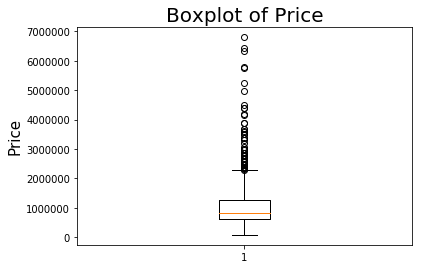

In [373]:
plt.boxplot(y_zolo['Price'])
plt.xlabel('')
plt.ylabel('Price', fontsize= 15)
plt.title('Boxplot of Price', fontsize= 20)

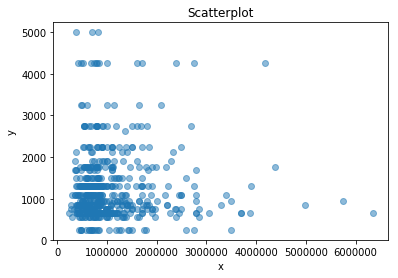

In [352]:
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')

plt.scatter(y_zolo['Price'], y_zolo['Sq_ft'], alpha=0.5)

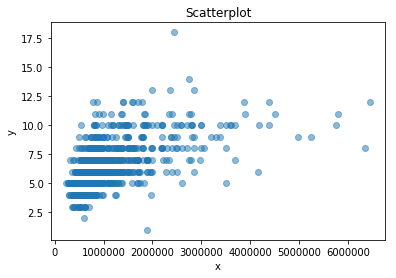

In [353]:
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')

plt.scatter(y_zolo['Price'], y_zolo['Rooms'], alpha=0.5)

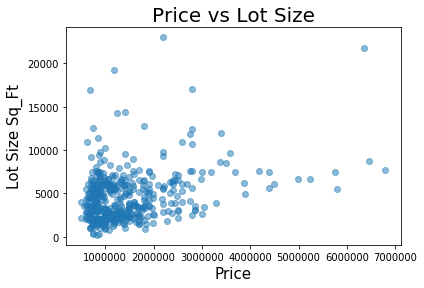

In [408]:
plt.xlabel('Price',fontsize = 15)
plt.ylabel('Lot Size Sq_Ft', fontsize = 15)
plt.title('Price vs Lot Size', fontsize = 20)

plt.scatter(y_zolo.loc[y_zolo['Lot Size Total']<30000,'Price'], y_zolo.loc[y_zolo['Lot Size Total']<30000,'Lot Size Total'], alpha=0.5)

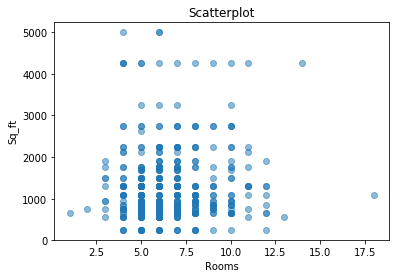

In [362]:
plt.xlabel('Rooms')
plt.ylabel('Sq_ft')
plt.title('Scatterplot')

plt.scatter(y_zolo['Rooms'], y_zolo['Sq_ft'], alpha=0.5)

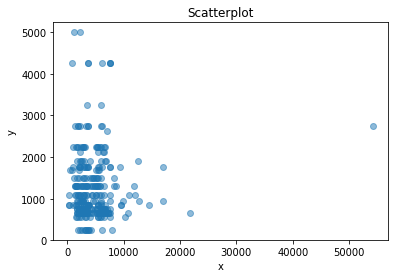

In [360]:
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')

plt.scatter(y_zolo['Lot Size Total'], y_zolo['Sq_ft'], alpha=0.5)

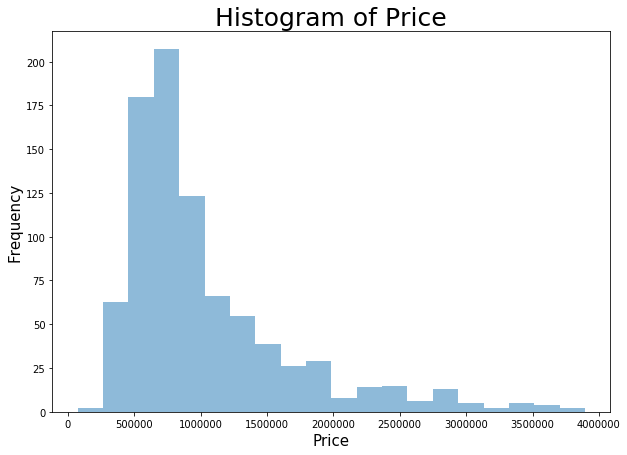

In [410]:
plt.figure()
plt.xlabel('Price',fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Histogram of Price', fontsize = 25)
y_zolo[y_zolo['Price']<4000000]['Price'].plot.hist(alpha=0.5, figsize=(10, 7), bins=20)

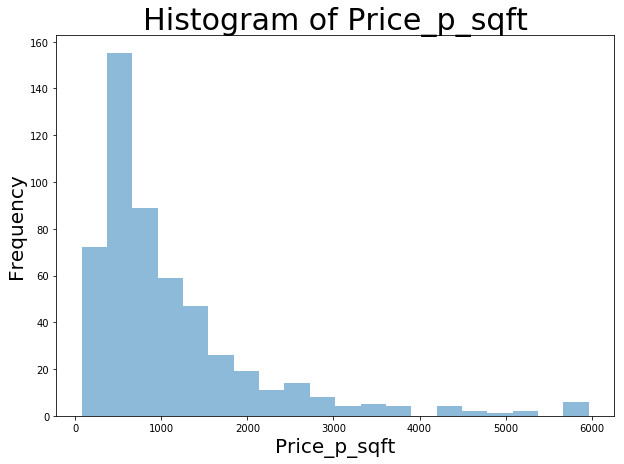

In [412]:
plt.figure()
plt.xlabel('Price_p_sqft',fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Histogram of Price_p_sqft', fontsize = 30)
y_zolo[y_zolo['Price_p_sqft']<=6000]['Price_p_sqft'].plot.hist(alpha=0.5, figsize=(10, 7), bins=20)

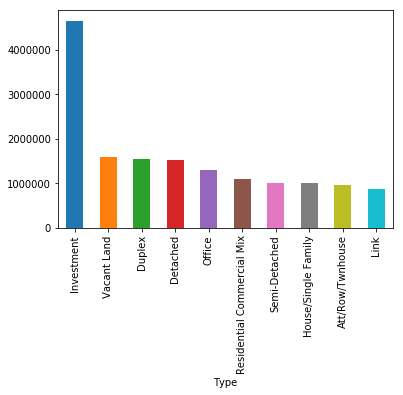

In [416]:
y_zolo.groupby('Type')['Price'].mean().sort_values(ascending=False).head(10).plot.bar()

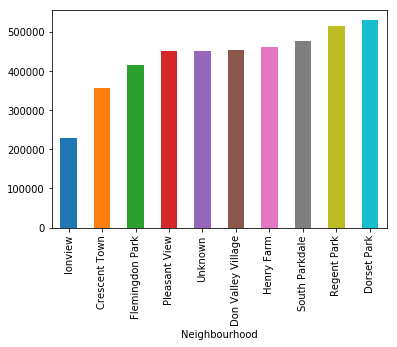

In [386]:
y_zolo.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=True).head(10).plot.bar()

### Please see PowerPoint Presentation for further insight into these outputs and visualizations. 

In [6]:
#See all columns of all data scraped
with pd.option_context('display.max_columns', None):
    display(y_zolo)

,index,Address,City,Neighbourhood,Price,Type,Style,Size,Age,Pets,Taxes,Maintenance Fees,Walk Score,MLS®#,Days on Site,Listed By,Size (sq ft),Property Type,Area,Community,Availability Date,Bedrooms,Bathrooms,Kitchens,Rooms,Patio Terrace,Air Conditioning,Stories,Heating,Parking Designation,Garage,Parking Places,Covered Parking Places,Lockers,Maintenance,Tax Year,Building Insurance Included,Common Elements Included,Parking Included,Fronting On,Cross Street,Municipality District,Corporation Number,Condo Registry Office,Association Name,Lot Size,Bedrooms Plus,Rooms Plus,Den/Family Room,Central Vac,Fireplace,Laundry,Basement,Kitchens Plus,Driveway,Tax Legal Description,Frontage,Lot Depth,Lot Size Units,Sewer,Virtual Tour,Acres,Other Structures,Electricity,Elevator,Exterior,Feature,Locker Quantity,Locker Level,Central A/C Included,Heating Included,Hydro Included,Amenity,UFFI,Zoning,Taxes Included,Parcel Number,Lot Irregularities,Share Percentage,Green Verification Rating,Parking Charges,Handicap Equipped,Assessment,Assesment Year,Parking Space,Year Built,Year built,Tytpe,Subdivision Name,Postal Code,Province,Ownership Type,Fireplace Features,Cooling,Fireplaces Total,Living Area,Building Area Units,Levels,Attached Garage,Parking Spaces,"Prominent Realty Inc., Brokerage",Century 21 Titans Realty Inc.,Re/max Royal Properties Realty,GreenProperty Info Statement,Green Verification Status
0,0,2070 - 3041 Finch Avenue,Toronto,Humbermede,"$346,790",Condo Apt,Stacked Townhse,500-599 sqft,No Data,Restrict,1280.26,$243 /mo,71,W4521263,"3 (Jul 18, 2019)","Zolo Realty, Brokerage",500-599,Residential,Toronto,Humbermede,Immd,1,1,1,4,Terr,Central Air,2,Forced Air,Level A Unt C10,Undergrnd,1,1,Owned,242.85,2019,Yes,Yes,Yes,W,Islington And Finch,Toronto W05,2000,TSCC,Castle Condo Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,238 Combe Avenue,Toronto,Bathurst Manor,"$1,999,000",Detached,2-Storey,3000-3500 sqft,No Data,NaN,8880,NaN,74,C4520362,"4 (Jul 17, 2019)","Zolo Realty, Brokerage",3000-3500,Residential,Toronto,Bathurst Manor,Tba,5,5,1,10,NaN,Central Air,NaN,Forced Air,NaN,Attached,5,1.5,NaN,NaN,2019,NaN,NaN,NaN,N,Wilson Heights/Sheppard,Toronto C06,NaN,NaN,NaN,52.21 x 115 Feet,2,3,Yes,Yes,Yes,"Upper, Upper level","Sep Entrance, Sep Entrance",Yes,Private,Pt Lt 24 Pl 1899 Twp Of York As In Ny696396; T...,52.21,115,Feet,Sewers,https://youtu.be/xVKB_qKCFBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,15 Reesor Road,Toronto,Rouge E11,"$1,399,000",Detached,2-Storey,No Data,No Data,NaN,3684.45,NaN,1,E4519836,"4 (Jul 16, 2019)","Zolo Realty, Brokerage",NaN,Residential,Toronto,Rouge E11,Tba,3,2,1,5,NaN,Central Air,NaN,Forced Air,NaN,Detached,16,2,NaN,NaN,2018,NaN,NaN,NaN,E,Steeles Ave And Reesor Rd,Toronto E11,NaN,NaN,NaN,No Data,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Private,Pt N1/2 Lt 6 Con 4 Scarborough As In Sc558775;...,1.98,NaN,Acres,Septic,https://youtu.be/rv4puEF-SC8,.50-1.99,Workshop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,60 Clappison Boulevard,Toronto,Centennial Scarborough,"$679,900",Semi-Detached,Bungalow-Raised,1100-1500 sqft,No Data,NaN,2907.87,NaN,58,E4518512,"5 (Jul 16, 2019)","Zolo Realty, Brokerage",1100-1500,Residential,Toronto,Centennial Scarborough,NaN,3,2,1,6,NaN,Central Air,NaN,Forced Air,NaN,Attached,4,1,NaN,NaN,2019,NaN,NaN,NaN,W,Port Union And Lawrence,Toronto E10,NaN,NaN,NaN,30.00 x 115 Feet,2,3,NaN,NaN,NaN,NaN,"Sep Entrance, Sep Entrance",NaN,Pvt Double,"Pt Lt 156, Pl 8658, As In Tb465774, S/T Sc 413730",30.00,115,Feet,Sewers,https://www.zolo.ca/toronto-real-estate/60